In [1]:
def multi_weighted_logloss(y_true, y_preds, classes, class_weights):
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')
    y_ohe = pd.get_dummies(y_true)
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    y_p_log = np.log(y_p)
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    class_arr = np.array([class_weights[k] for k in sorted(class_weights.keys())])
    y_w = y_log_ones * class_arr / nb_pos
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss


def lgbm_multi_weighted_logloss(y_true, y_preds):
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weights = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    loss = multi_weighted_logloss(y_true, y_preds, classes, class_weights)
    return 'wloss', loss, False

In [56]:
import pandas as pd


train = pd.read_feather('data/train.fth').set_index('object_id')
test = pd.read_feather('data/test.fth').set_index('object_id')

X_train = train.drop(columns='target')
y_train = train['target'].apply(lambda x: int(x.split('_')[1]))
X_test = test

submission = pd.DataFrame(0., index=X_test.index, columns=y_train.cat.categories)

class_to_int = {c: i for i, c in enumerate(sorted(y_train.unique()))}
int_to_class = {i: c for c, i in class_to_int.items()}

class_weights = (len(y_train) / y_train.value_counts()).to_dict()
class_weights

/home/max/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


{90: 3.3929961089494163,
 42: 6.57837384744342,
 65: 8.0,
 16: 8.493506493506494,
 15: 15.854545454545455,
 62: 16.214876033057852,
 88: 21.21081081081081,
 92: 32.83682008368201,
 67: 37.73076923076923,
 52: 42.885245901639344,
 95: 44.84571428571429,
 6: 51.973509933774835,
 64: 76.94117647058823,
 53: 261.6}

Define the loss.

In [69]:
import lightgbm as lgb
import numpy as np
from sklearn import model_selection


model = lgb.LGBMClassifier(
    num_leaves=2 ** 3,
    n_estimators=10000,
    learning_rate=0.03,
    min_data_in_leaf=200,
    feature_fraction=0.5,
    reg_alpha=0.1,
    feature_fraction_seed=42
)

cv = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
feature_importances = pd.DataFrame(index=X_train.columns)
fit_scores = np.zeros(cv.n_splits)
val_scores = np.zeros(cv.n_splits)
val_preds = pd.Series(0, index=X_train.index)
submission[:] = 0.0


for i, (fit_idx, val_idx) in enumerate(cv.split(X_train, y_train)):

    X_fit = X_train.iloc[fit_idx]
    y_fit = y_train.iloc[fit_idx].map(class_to_int)
    w_fit = y_train.iloc[fit_idx].map(class_weights)
    X_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx].map(class_to_int)

    evals_result = {}
    model = model.fit(
        X=X_fit,
        y=y_fit,
        sample_weight=w_fit,
        eval_set=[(X_fit, y_fit), (X_val, y_val)],
        eval_names=('fit', 'val'),
        eval_metric=lgbm_multi_weighted_logloss,
        verbose=100,
        early_stopping_rounds=20
    )

    # Store the feature importances
    feature_importances[i] = model.feature_importances_

    # Store the scores
    fit_scores[i] = model.evals_result_['fit']['wloss'][model.best_iteration_ - 1]
    val_scores[i] = model.evals_result_['val']['wloss'][model.best_iteration_ - 1]

    # Store the test predictions
    y_pred = pd.DataFrame(model.predict_proba(X_test), index=X_test.index)
    y_pred.columns = y_pred.columns.map(int_to_class)
    submission.loc[y_pred.index, y_pred.columns] += y_pred / cv.n_splits
    
    # Store the validation predictions
    val_preds.iloc[val_idx] = np.argmax(model.predict_proba(X_val), axis=1)
    
    print() # Separation for readability

print(f'- Train loss: {fit_scores.mean():.3f} (±{fit_scores.std():.3f})')
print(f'- Valid loss: {val_scores.mean():.3f} (±{val_scores.std():.3f})')

Training until validation scores don't improve for 20 rounds.
[100]	fit's multi_logloss: 0.642667	fit's wloss: 0.631879	val's multi_logloss: 0.951408	val's wloss: 0.767652
[200]	fit's multi_logloss: 0.372417	fit's wloss: 0.361458	val's multi_logloss: 0.713236	val's wloss: 0.557567
[300]	fit's multi_logloss: 0.267853	fit's wloss: 0.256824	val's multi_logloss: 0.63109	val's wloss: 0.520792
Early stopping, best iteration is:
[349]	fit's multi_logloss: 0.23557	fit's wloss: 0.224776	val's multi_logloss: 0.607939	val's wloss: 0.516326

Training until validation scores don't improve for 20 rounds.
[100]	fit's multi_logloss: 0.635167	fit's wloss: 0.62513	val's multi_logloss: 0.949057	val's wloss: 0.766315
[200]	fit's multi_logloss: 0.36527	fit's wloss: 0.355137	val's multi_logloss: 0.714643	val's wloss: 0.567189
[300]	fit's multi_logloss: 0.262415	fit's wloss: 0.252335	val's multi_logloss: 0.631207	val's wloss: 0.5224
[400]	fit's multi_logloss: 0.204802	fit's wloss: 0.195234	val's multi_loglos

In [ ]:
- Train loss: 0.210 (±0.030)
- Valid loss: 0.553 (±0.034)

- Train loss: 0.215 (±0.026)
- Valid loss: 0.540 (±0.030)

Class 99.

In [73]:
def GenUnknown(data):
    return ((((((data["mymedian"]) + (((data["mymean"]) / 2.0)))/2.0)) + (((((1.0) - (((data["mymax"]) * (((data["mymax"]) * (data["mymax"]))))))) / 2.0)))/2.0)


feats = ['class_6', 'class_15', 'class_16', 'class_42', 'class_52', 'class_53',
         'class_62', 'class_64', 'class_65', 'class_67', 'class_88', 'class_90',
         'class_92', 'class_95']

submission = submission.add_prefix('class_')
y = pd.DataFrame()
y['mymean'] = submission[feats].mean(axis=1)
y['mymedian'] = submission[feats].median(axis=1)
y['mymax'] = submission[feats].max(axis=1)

submission['class_99'] = GenUnknown(y)

In [79]:
gal_classes = ['class_6', 'class_16', 'class_53', 'class_65', 'class_92']
ex_classes = list(set(submission.columns.difference(set(gal_classes + ['class_99']))))

submission.loc[X_test['is_galactic'], ex_classes] = 0.
submission.loc[~X_test['is_galactic'], gal_classes] = 0.

In [80]:
submission.head()

,class_15,class_16,class_42,class_52,class_53,class_6,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
object_id,,,,,,,,,,,,,,,
13,0.002153,0.0,0.611702,0.089650,0.0,0.0,0.077100,0.000375,0.0,0.007010,0.000518,0.207799,0.0,0.001227,0.201966
14,0.013126,0.0,0.152431,0.024578,0.0,0.0,0.062966,0.000826,0.0,0.024547,0.037806,0.670522,0.0,0.009727,0.186419
17,0.011570,0.0,0.076102,0.027908,0.0,0.0,0.039767,0.017416,0.0,0.047956,0.048469,0.715396,0.0,0.012024,0.171075
23,0.002146,0.0,0.067313,0.011786,0.0,0.0,0.051377,0.010756,0.0,0.310117,0.002174,0.534301,0.0,0.008017,0.222070
34,0.002119,0.0,0.048119,0.090006,0.0,0.0,0.017808,0.000202,0.0,0.015248,0.000402,0.823910,0.0,0.000684,0.119251


In [81]:
sample_sub = pd.read_csv('data/kaggle/sample_submission.csv').set_index('object_id')
name = f'{fit_scores.mean():.3f}_{fit_scores.std():.3f}_{val_scores.mean():.3f}_{val_scores.std():.3f}'
submission.loc[sample_sub.index, sample_sub.columns].to_csv(f'submissions/{name}.csv.gz', compression='gzip')

Normalized confusion matrix


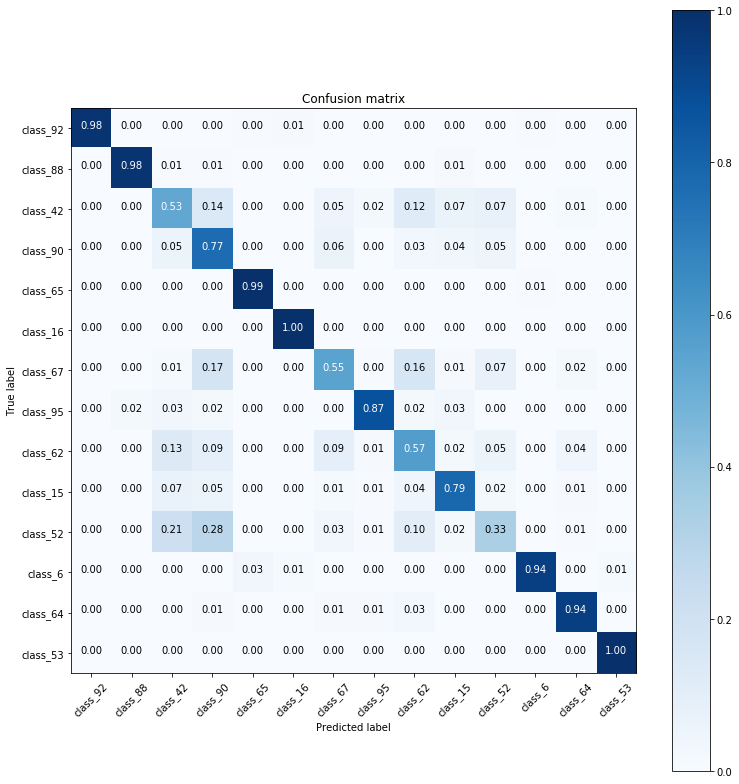

In [44]:
import itertools

import matplotlib.pyplot as plt
from sklearn import metrics

%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = metrics.confusion_matrix(y_train.map(class_to_int), val_preds)
plt.figure(figsize=(11, 11))
plot_confusion_matrix(cm, int_to_class.values(), True)

In [ ]:
feature_importances.sort_values('gain_0', ascending=False)